In [10]:
# !pip install yfinance pandas matplotlib scikit-learn

In [11]:
import yfinance as yf  # 금융 데이터 다운로드 및 Yahoo Finance API 사용
import pandas as pd  # 데이터 조작 및 분석을 위한 DataFrame 처리
import numpy as np  # 수학적 연산과 배열 조작을 위한 라이브러리
import torch  # PyTorch를 사용한 신경망 구현 및 연산
import torch.nn as nn  # PyTorch의 신경망 모듈 정의 및 레이어 구성
from torch.autograd import Variable  # 텐서를 자동 미분할 수 있도록 래핑하는 유틸리티
from sklearn.preprocessing import StandardScaler  # 데이터를 표준화하기 위한 스케일링 도구
import torch.nn.functional as F  # PyTorch에서 제공하는 다양한 활성화 함수 및 손실 함수
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
import os  # 디렉토리 및 파일 시스템 관리를 위한 라이브러리
from torch.utils.data import DataLoader, TensorDataset, random_split  # PyTorch에서 데이터셋을 관리하고 로드 및 텐서를 처리하는 도구

In [12]:
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# 삼성 주가 데이터 다운로드
ticker = "005930.KS"  # 삼성전자의 한국 거래소 코드
df = yf.download(ticker, start="2018-01-01", end="2024-11-05")  # 지정된 기간 동안 삼성전자의 주가 데이터를 다운로드
df = df[['Open', 'High', 'Low', 'Close']]  # 필요한 열(시가, 고가, 저가, 종가)만 선택, df 모양: [행 개수, 4] (예: [1500, 4] 행의 개수는 데이터 수에 따라 달라질 수 있음)

# 데이터 전처리
scaler = StandardScaler()  # 데이터를 평균 0, 표준편차 1로 표준화하기 위해 StandardScaler 초기화
scaled_data = scaler.fit_transform(df)  # 데이터프레임을 표준화하여 변환, scaled_data 모양: [행 개수, 4] (예: [1500, 4] 표준화된 데이터)



[*********************100%***********************]  1 of 1 completed


In [13]:
# LSTM 모델 클래스 정의
class LSTMModel(nn.Module):  # PyTorch의 LSTM 모델을 정의하는 클래스입니다.
    def __init__(self, input_size=4, hidden_size=128, output_size=1, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()  # 부모 클래스(nn.Module)의 생성자를 호출합니다.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)  # LSTM 레이어 정의 (입력 크기: 4, 은닉 크기: 128, 레이어 수: 2)
        self.fc = nn.Linear(hidden_size, output_size)  # LSTM 출력 후 완전 연결 레이어 (128 -> 1 변환)
        self.relu = nn.ReLU()  # 활성화 함수 ReLU 정의

    def forward(self, x):  # 순전파 함수 정의
        lstm_out, _ = self.lstm(x)  # LSTM의 출력 계산, lstm_out 모양: [배치 크기, 시퀀스 길이, 은닉 크기] -> [2, 10, 128]
        last_out = lstm_out[:, -1, :]  # 마지막 시퀀스의 출력을 선택, last_out 모양: [배치 크기, 은닉 크기] -> [2, 128]
        out = self.fc(self.relu(last_out))  # ReLU 활성화 후 완전 연결 레이어 통과, out 모양: [배치 크기, 출력 크기] -> [2, 1]
        return out

# 가중치 초기화 함수 정의
def init_weights(m):  # 모델의 가중치 초기화 함수
    if isinstance(m, nn.Linear):  # nn.Linear 레이어의 경우
        nn.init.xavier_uniform_(m.weight)  # Linear 레이어의 가중치를 Xavier 초기화
        nn.init.zeros_(m.bias)  # Linear 레이어의 편향을 0으로 초기화
    elif isinstance(m, nn.LSTM):  # nn.LSTM 레이어의 경우
        for name, param in m.named_parameters():  # LSTM 레이어의 파라미터 이름과 값 탐색
            if 'weight' in name:
                nn.init.xavier_uniform_(param)  # LSTM 가중치를 Xavier 초기화
            elif 'bias' in name:
                nn.init.zeros_(param)  # LSTM 편향을 0으로 초기화

#
# 예시 입력 데이터
model = LSTMModel()  # LSTM 모델 인스턴스 생성
model.apply(init_weights)  # 가중치 초기화 적용

# 예시 입력 데이터 (배치 크기: 2, 시퀀스 길이: 10, 입력 크기: 4)
sample_data = torch.randn(2, 10, 4)  # [배치 크기, 시퀀스 길이, 입력 크기] -> [2, 10, 4]
output = model(sample_data)  # 모델에 데이터 통과
print(output)  # 예측 결과 출력, 출력 모양: [2, 1]

tensor([[ 0.0049],
        [-0.0027]], grad_fn=<AddmmBackward0>)


In [14]:
import os  # 운영체제와의 상호작용을 위한 라이브러리
# 구글 드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')  # Google Drive를 Colab에 마운트하여 파일에 접근

# 훈련 및 테스트 데이터 분할
train_size = int(len(scaled_data) * 0.8)  # 데이터의 80%를 훈련 데이터로 설정
train_data = scaled_data[:train_size]  # 훈련 데이터 분할, train_data 모양: [행 개수 * 0.8, 4] (예: [1200, 4] 데이터 수에 따라 달라질 수 있음)
test_data = scaled_data[train_size:]  # 테스트 데이터 분할, test_data 모양: [행 개수 * 0.2, 4] (예: [300, 4])

# 시계열 데이터를 일정 길이의 시퀀스로 변환하는 함수
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]  # 일정 길이의 시퀀스 생성, seq 모양: [sequence_length, 4] (예: [30, 4])
        label = data[i+sequence_length][3]  # 시퀀스 이후의 종가(label)를 예측값으로 설정
        sequences.append((seq, label))  # seq와 label을 튜플로 저장
    return sequences

sequence_length = 30  # 시퀀스 길이를 30일로 설정
train_sequences = create_sequences(train_data, sequence_length)  # 훈련 데이터 시퀀스 생성, train_sequences 예시: [(seq1, label1), (seq2, label2), ...]
test_sequences = create_sequences(test_data, sequence_length)  # 테스트 데이터 시퀀스 생성, test_sequences 예시: [(seq1, label1), (seq2, label2), ...]

# 데이터셋 생성
class StockDataset(torch.utils.data.Dataset):  # PyTorch 데이터셋 클래스를 상속받아 사용자 정의 데이터셋 생성
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):  # 데이터셋의 길이 반환
        return len(self.sequences)

    def __getitem__(self, idx):  # 주어진 인덱스의 시퀀스와 레이블 반환
        seq, label = self.sequences[idx]  # seq 모양: [30, 4], label: 단일 값 (예: 0.75)
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

train_dataset = StockDataset(train_sequences)  # 훈련 데이터셋 생성, 길이 예시: len(train_sequences)
test_dataset = StockDataset(test_sequences)  # 테스트 데이터셋 생성, 길이 예시: len(test_sequences)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # 훈련 데이터 로더 생성, batch_size 64
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # 테스트 데이터 로더 생성, batch_size 64


In [15]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 사용 가능하면 사용하고, 그렇지 않으면 CPU 사용

# 모델 생성 및 디바이스로 이동
model = LSTMModel().to(device)  # LSTM 모델 인스턴스를 생성하고 디바이스로 이동
model.apply(init_weights)  # 모델 가중치 초기화 적용

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()  # 평균 제곱 오차(MSE) 손실 함수 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Adam 옵티마이저와 L2 정규화(weight decay) 설정
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)  # 학습률 조정 스케줄러 설정

# 모델 학습
num_epochs = 50  # 학습 에포크 수 설정
# 손실 값 저장 리스트 추가
epoch_losses = []  # 에포크별 손실을 저장할 리스트 (예: [0.35, 0.25, ...])
test_losses = []  # 에포크별 테스트 손실을 저장할 리스트
clip_value = 1.0  # Gradient Clipping 값 설정 (기울기가 1을 초과하지 않도록 제한)
for epoch in range(num_epochs):  # 각 에포크 동안 학습 루프 (예: num_epochs=50일 때 50회 반복)
    model.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등이 학습 모드로 작동)
    total_loss = 0  # 총 손실 초기화
    for seq, label in train_loader:  # 훈련 데이터를 배치 단위로 처리 (예: 배치 크기 64)
        seq, label = seq.to(device), label.to(device)  # 데이터를 디바이스로 이동 (예: seq shape [64, 30, 4], label shape [64])
        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        output = model(seq)  # 모델의 예측값 계산 (예: output shape [64, 1])
        loss = criterion(output, label.unsqueeze(-1))  # 손실 계산 (출력 차원 맞추기 위해 unsqueeze 사용, 예: label.unsqueeze(-1) shape [64, 1])
        loss.backward()  # 역전파로 기울기 계산
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)  # Gradient Clipping 적용 (기울기를 최대 clip_value로 제한)
        optimizer.step()  # 가중치 업데이트 (학습률에 따라 가중치 조정)
        total_loss += loss.item()  # 손실 값 누적 (예: total_loss += 0.12)
    scheduler.step()  # 학습률 조정 (예: 15 에포크마다 lr * 0.5로 감소)
    average_loss = total_loss / len(train_loader)  # 에포크별 평균 손실 계산 (예: total_loss / num_batches)
    epoch_losses.append(average_loss)  # 에포크별 평균 손실 저장 (예: [0.35, 0.25, ...])

    # 테스트 모드
    model.eval()  # 모델을 평가 모드로 설정
    test_loss = 0  # 테스트 손실 초기화
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for seq, label in test_loader:  # 테스트 데이터를 배치 단위로 처리
            seq, label = seq.to(device), label.to(device)  # 데이터를 디바이스로 이동
            output = model(seq)  # 모델의 예측값 계산
            loss = criterion(output, label.unsqueeze(-1))  # 손실 계산
            test_loss += loss.item()  # 손실 값 누적
    average_test_loss = test_loss / len(test_loader)  # 에포크별 평균 테스트 손실 계산
    test_losses.append(average_test_loss)  # 에포크별 테스트 손실 저장
   # 손실 값 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}")  # 훈련 및 테스트 손실 출력

# 모델 저장
model_weight_save_path = "./"  # 모델 가중치를 저장할 경로 지정
os.makedirs(model_weight_save_path, exist_ok=True)  # 지정된 경로가 없으면 새로 생성
torch.save(model.state_dict(), os.path.join(model_weight_save_path, 'samsungStock_LSTM_60days_basic.pth'))  # LSTM 모델의 가중치 저장
torch.save(scaler, os.path.join(model_weight_save_path, 'scaler_LSTM_60days_basic.pth'))  # 데이터 스케일러 저장

Epoch 1/50, Train Loss: 0.5156, Test Loss: 0.1575
Epoch 2/50, Train Loss: 0.0424, Test Loss: 0.0399
Epoch 3/50, Train Loss: 0.0226, Test Loss: 0.0257
Epoch 4/50, Train Loss: 0.0172, Test Loss: 0.0173
Epoch 5/50, Train Loss: 0.0156, Test Loss: 0.0204
Epoch 6/50, Train Loss: 0.0149, Test Loss: 0.0153
Epoch 7/50, Train Loss: 0.0143, Test Loss: 0.0144
Epoch 8/50, Train Loss: 0.0136, Test Loss: 0.0138
Epoch 9/50, Train Loss: 0.0137, Test Loss: 0.0160
Epoch 10/50, Train Loss: 0.0130, Test Loss: 0.0155
Epoch 11/50, Train Loss: 0.0119, Test Loss: 0.0171
Epoch 12/50, Train Loss: 0.0130, Test Loss: 0.0119
Epoch 13/50, Train Loss: 0.0114, Test Loss: 0.0134
Epoch 14/50, Train Loss: 0.0116, Test Loss: 0.0115
Epoch 15/50, Train Loss: 0.0117, Test Loss: 0.0110
Epoch 16/50, Train Loss: 0.0106, Test Loss: 0.0111
Epoch 17/50, Train Loss: 0.0102, Test Loss: 0.0109
Epoch 18/50, Train Loss: 0.0157, Test Loss: 0.0107
Epoch 19/50, Train Loss: 0.0108, Test Loss: 0.0122
Epoch 20/50, Train Loss: 0.0103, Test Lo

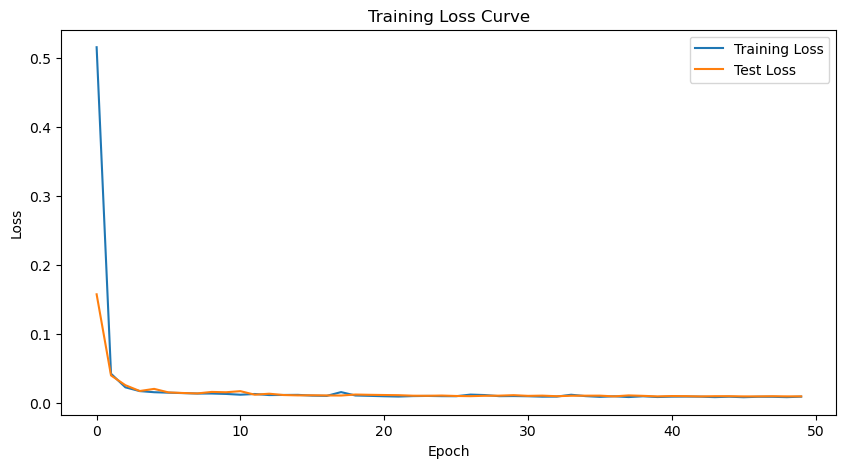

In [16]:
# 손실 값 그래프 시각화
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.plot(range(num_epochs), epoch_losses, label='Training Loss')  # 에포크별 손실 값 그래프 그리기
plt.plot(test_losses, label="Test Loss")  # 테스트 손실을 그래프로 그리기
plt.xlabel('Epoch')  # x축 레이블 설정
plt.ylabel('Loss')  # y축 레이블 설정
plt.title('Training Loss Curve')  # 그래프 제목 설정
plt.legend()  # 범례 추가
plt.show()  # 그래프 출력


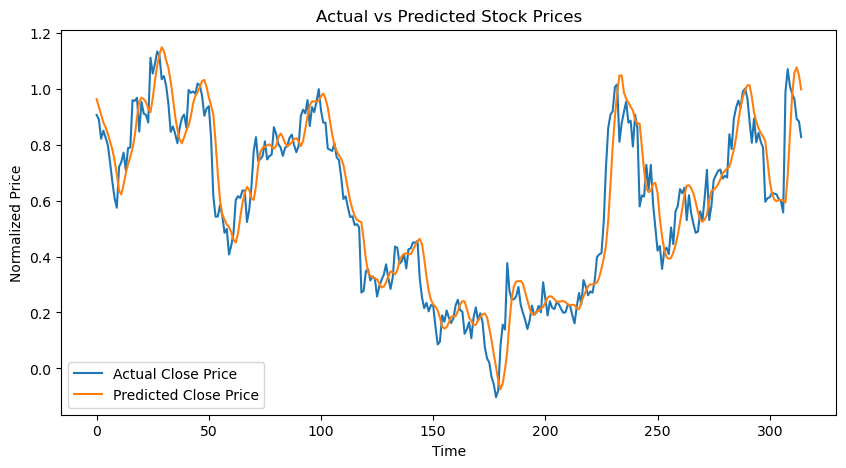

In [17]:
# 예측 생성 및 시각화
model.eval()  # 모델을 평가 모드로 설정 (드롭아웃 등 비활성화)
predictions = []  # 예측값을 저장할 리스트 초기화
actuals = []  # 실제 값을 저장할 리스트 초기화

with torch.no_grad():  # 그래디언트 계산 비활성화 (평가 시 메모리 사용 감소)
    for seq, label in test_loader:  # 테스트 데이터 로더에서 시퀀스와 레이블 가져오기
        seq, label = seq.to(device), label.to(device)  # 데이터를 디바이스로 이동 (예: GPU)
        output = model(seq)  # 모델을 사용하여 예측값 생성, output 모양 예시: [배치 크기, 1] (예: [64, 1])
        predictions.append(output.cpu().numpy())  # 예측값을 CPU로 이동 후 numpy로 변환하여 저장
        actuals.append(label.cpu().numpy())  # 실제값을 CPU로 이동 후 numpy로 변환하여 저장

predictions = np.concatenate(predictions).flatten()  # 예측값을 하나의 배열로 결합하고 평탄화, 모양 예시: [전체 예측 개수]
actuals = np.concatenate(actuals).flatten()  # 실제값을 하나의 배열로 결합하고 평탄화, 모양 예시: [전체 예측 개수]

plt.figure(figsize=(10, 5))  # 시각화 크기 설정
plt.plot(actuals, label='Actual Close Price')  # 실제 종가 그래프 생성
plt.plot(predictions, label='Predicted Close Price')  # 예측된 종가 그래프 생성
plt.xlabel('Time')  # X축 라벨 설정
plt.ylabel('Normalized Price')  # Y축 라벨 설정
plt.title('Actual vs Predicted Stock Prices')  # 그래프 제목 설정
plt.legend()  # 범례 추가
plt.show()  # 그래프 표시


In [18]:
# 다음 날 종가 예측 (마지막 60일 데이터 사용)
last_60_days = scaled_data[-60:]
last_60_days_tensor = torch.tensor(last_60_days, dtype=torch.float32).unsqueeze(0).to(device)
with torch.no_grad():
    next_day_prediction = model(last_60_days_tensor).cpu().item()
next_day_prediction_actual = scaler.inverse_transform([[0, 0, 0, next_day_prediction]])[0][3]
print(f"Predicted next day's closing price: {next_day_prediction_actual:.2f}")

Predicted next day's closing price: 254.08
